## The case for Area as the fundamental unit

This notebook contains a prototype for exploring the case for area as the fundamental unit of measure instead of the volume, following the description here: https://docs.google.com/document/d/1GVUEv8l9T3zogKvIThCUAWN_tbZdpu2-MbE3PyOQepw/edit#heading=h.9qcog0t53hjq

The idea behind would be to use Purchase Area as equivalent to Volume (i.e. _what is the area required to produce the purchased volume?_)

For that we need the yield in each location to distribute that area. Ths can be done following this formula if we have pixel-resolution yield:

	f’ = f.V / a.y Σf
    
- f': fractional area used to produce the commodity such that the sum of all pixels within some area of interest equals the Purchase Area (unitless)

- f: the (estimated) fractional area used to to produce the commodity, where Σf is equal to the total possible commodity production area (unitless)

- a: pixel area (ha)

- y: the yeild of the commodity in a given pixel (t/ha)

- V: the known purchased Volume (t)

### 1. Import libraries:

In [38]:
## import libraries
import geopandas as gpd
import time

from rasterstats import zonal_stats
import rasterio as rio
import rasterio.plot
import matplotlib.pyplot as plt

### 2. Import user data



In [2]:
## import user data
input_data = gpd.read_file('../../datasets/processed/located_lg_data_polygon_v2.shp') 
input_data.head()

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,Rubber,None,2400,China,None,None,None,Unknown,Low,"MULTIPOLYGON (((73.49973 39.38174, 73.50468 39..."
1,Rubber,None,1300,Malaysia,None,None,None,Unknown,Low,"MULTIPOLYGON (((98.93721 5.68384, 98.93771 5.6..."
2,Rubber,None,1000,United States,None,None,None,Unknown,Low,"MULTIPOLYGON (((-180.00000 51.79409, -180.0000..."
3,Rubber,None,730,Japan,None,None,None,Unknown,Low,"MULTIPOLYGON (((122.71418 24.44983, 122.71457 ..."
4,Rubber,None,490,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23..."


We are going to use a test location from the user data to generate the purchase area probability map. Therefore we're going to select a test location from the gdf above:

In [8]:
test_gdf = input_data.loc[(input_data['Material']=='Cotton') & (input_data['Country']=='India') & ((input_data['Volume']==745) )]
test_gdf

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
18,Cotton,None,745,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23..."


In [13]:
test_gdf.to_file('../../datasets/raw/india_test_shape.shp', driver='ESRI Shapefile')

### 3. Generate purchase area probability map

For the purchase area probability map we will need:

- The purchased volume which is provided by the user as we can see above
- The area fraction for the commodity of interest (in this case cotton) - obtained from EarthStat
- The yield of the commodity of interest (in this case cotton) - obtained from EarthStat

The formula (per pixel) is:

`f' = V/At * f/y`

- V = Volume of commodity Purchased (const)
- f = Area Fraction used to produce commodity (per pixel)
- At = Total area used to produce ALL of the commodity (const)
    - where At = `a*sum(f)` i.e. integrated pixel area * f
- a = pixel area
- y = Commodity yield (per pixel)

We then have a measure of the likelihood that the purchased commoity was sources inside a given pixel (0-1). 

From there we need to locate deforestation pixels and associate them with commodity pixels

Then, `Ap = sum(a*f')`

In [11]:
yield_cotton = '../../datasets/raw/cotton_YieldPerHectare.tif'
harvest_portion_cotton = '../../datasets/raw/cotton_HarvestedAreaFraction.tif'


#### 3.1. Generate raster with volume info

In [16]:
!gdalinfo -stats -hist '../../datasets/raw/cotton_HarvestedAreaFraction.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/cotton_HarvestedAreaFraction.tif
Size is 4320, 2160
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,89.999999999989768)
Pixel Size = (0.083333333333329,-0.083333333333329)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_SOFTWARE=MATLAB 8.0, Mapping Toolbox 3.6
Image Structure Metadata:
  COMPRESSION=PACKBITS
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-180.0000000,  90.0000000) (180d 0' 0.00"W, 90d 0' 0

In [19]:
## generate a raster with same resolution as the yield and harvest portion
## with the user volume
!gdal_rasterize -l india_test_shape -a Volume -tr 0.0833333333333286 0.0833333333333286 -a_nodata 0.0 -te -180.0 -90.0 180.0 90.0 -ot Float32 -of GTiff '../../datasets/raw/india_test_shape.shp' '../../datasets/raw/india_test_raster_volume.tif'

0...10...20...30...40...50...60...70...80...90...100 - done.


In [21]:
## add projection - same as the other ones for the calculations
!gdal_edit.py -a_srs EPSG:4326 '../../datasets/raw/india_test_raster_volume.tif'

### 3.2. Obtain raster with total fraction area

In [26]:
#zonal stats in india to get the sum of all fraction harvest area
start_time = time.time()
zs_india_test = zonal_stats(
    test_gdf,
    harvest_portion_cotton,
    stats="sum")
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2757606506347656 seconds ---


/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [29]:
zs_india_test[0]['sum']

902.6503295898438

In [30]:
## ad field to gdf
test_gdf['Total_af'] = zs_india_test[0]['sum']
test_gdf

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry,Total_af
18,Cotton,None,745,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23...",902.65033


In [31]:
test_gdf.to_file('../../datasets/raw/india_test_shape.shp', driver='ESRI Shapefile')

In [32]:
## generate a raster with same extent as the other ones with this total area fraction value
!gdal_rasterize -l india_test_shape -a Total_af -tr 0.0833333333333286 0.0833333333333286 -a_nodata 0.0 -te -180.0 -90.0 180.0 90.0 -ot Float32 -of GTiff '../../datasets/raw/india_test_shape.shp' '../../datasets/raw/india_test_raster_total_af.tif'


0...10...20...30...40...50...60...70...80...90...100 - done.


In [33]:
## add projection - same as the other ones for the calculations
!gdal_edit.py -a_srs EPSG:4326 '../../datasets/raw/india_test_raster_total_af.tif'

### 3.3. Calculate probability map

The formula would be: 

    f' = (V * Af) / (AT * Yield)
    

In [34]:
!gdal_calc.py -A '../../datasets/raw/india_test_raster_volume.tif' -B '../../datasets/raw/cotton_HarvestedAreaFraction.tif' -C '../../datasets/raw/india_test_raster_total_af.tif' -D '../../datasets/raw/cotton_YieldPerHectare.tif' --outfile='../../datasets/processed/purchase_area_distribution_cotton_4326.tif' --calc="(A*B)/(C*D)"

<string>:1: RuntimeWarning: invalid value encountered in true_divide
0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10

In [36]:
!gdalinfo -stats -hist '../../datasets/processed/purchase_area_distribution_cotton_4326.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/purchase_area_distribution_cotton_4326.tif
Size is 4320, 2160
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,90.000000000000000)
Pixel Size = (0.083333333333329,-0.083333333333329)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-180.0000000,  90.0000000) (180d 0' 0.00"W, 90d 0' 0.00"N)
Lower Left  (-180.0000000, -90.0000000) (180d 0' 0.

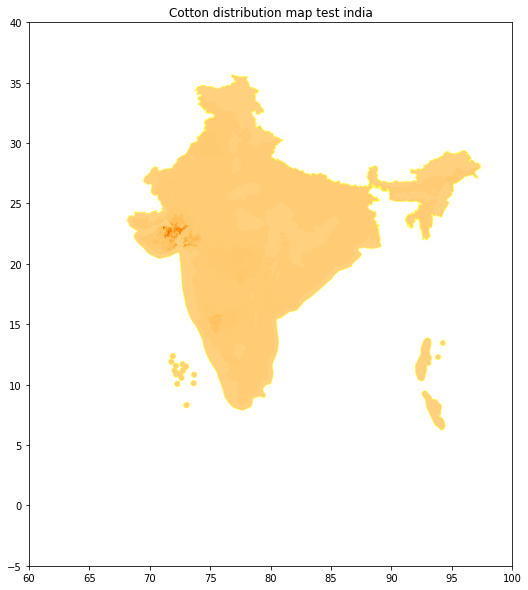

In [39]:
#check calculated risk map
with rio.open( '../../datasets/processed/purchase_area_distribution_cotton_4326.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((-5,40))
    ax.set_xlim((60,100))
    rio.plot.show(dat, vmin=1.0376739745244e-10, vmax=3.0921504497528, cmap='Oranges', ax=ax, transform=src.transform)
    test_gdf.plot(ax=ax, alpha=0.5, color='Orange', edgecolor='yellow')
    ax.set_title('Cotton distribution map test india')